# SNF + HDBSCAN Clustering for patients sub-group identification

Clustering dei dati basato su genus citochine e clinici, cercando di indiviaduare corrispondenze su risposta alla terapia e valori ematologici

In [1]:
import pandas as pd
import snf
import numpy as np
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

Parameters of the analysis:
- metric: "cosine" or "euclidean"
- type_input: "cytokines", "genera" and/or "clinical_norm"
- dim_red: "tsne" or "pca"

In [2]:
metric = 'cosine'
type_input = ["cytokines","genera"]#, "clinical_norm"]
dim_red = "pca"

Import data The must be a PxF matrix, where P is number of patients and F is number of features. If there are missing values the algorithm works ayway

In [3]:
genera = pd.read_csv('./dati/test/genera.csv', header = 0, index_col='id')
cyto = pd.read_csv('./dati/test/cytokines.csv', header = 0, index_col='id')
clinical_original     = pd.read_csv('./dati/test/clinical_carmen.csv', header = 0, index_col='id')
# clinical_original = clinical_original.drop(columns=["zonulina"])
# clinical_original = clinical_original.drop([4, 23, 34])


# clinical_original = clinical_original.drop([4,23, 34])
names = clinical_original["id_microbio"]

# drop patient OM-004 from cyto because it's not present in genera
cyto = cyto.drop([4, 23, 34])
# cyto = cyto.drop(columns=["SCGF-b"])


clinical = clinical_original.copy()
# clinical = clinical.drop(columns=["mr","id_microbio", "Unnamed: 0", "data_diagnosi", "data_iniz_terapia", "data_ultima_dose", "data_ultima_infez", "data_prelievo"])
clinical['age_category'] = clinical['age_molecular'].apply(lambda x: 1 if x < 60 else 0)

Normalize clinical data and map the categorigal variables to integers

In [4]:
label_encoder = LabelEncoder()
clinical_encoded = clinical.copy()

for col in clinical.columns:
    clinical_encoded[col] = label_encoder.fit_transform(clinical[col].astype(str))
normalizer_clinical = MinMaxScaler(feature_range=(0,1))
normalizer_clinical.fit(clinical_encoded)
clinical_norm = pd.DataFrame(normalizer_clinical.transform(clinical_encoded.copy()), columns=clinical_encoded.columns)
print(f"Shape of clinical data matrix: {clinical_norm.shape}")

Shape of clinical data matrix: (43, 13)


Normalize microbio data

In [5]:
#normalize data with minmax

normalizer_genera = MinMaxScaler(feature_range=(0,1))
normalizer_genera.fit(genera)
genera_norm = pd.DataFrame(normalizer_genera.transform(genera.copy()), columns=genera.columns)
print(f"Shape of genus data matrix: {genera_norm.shape}")

Shape of genus data matrix: (43, 86)


Normalize cytokines data

In [6]:
normalizer_cyto = MinMaxScaler(feature_range=(0,1))
normalizer_cyto.fit(cyto)
cyto_norm = pd.DataFrame(normalizer_cyto.transform(cyto.copy()), columns=cyto.columns)
print(f"Shape of cytokynes data matrix: {cyto_norm.shape}")

Shape of cytokynes data matrix: (43, 27)


Calculate affinity matrices and put the matrices in a list

In [7]:
affinities = []

for data in type_input:
    if data == "clinical_norm":
        data_array = clinical_norm.astype(float).values
        affinity = snf.make_affinity(data_array, metric="jaccard")
    if data == "genera":
        data_array = genera_norm.astype(float).values
        affinity = snf.make_affinity(data_array, metric=metric)
    if data == "cytokines":
        data_array = cyto_norm.astype(float).values
        affinity = snf.make_affinity(data_array, metric=metric)
    affinities.append(affinity)


Plot heatmaps of the anìffinity matrices

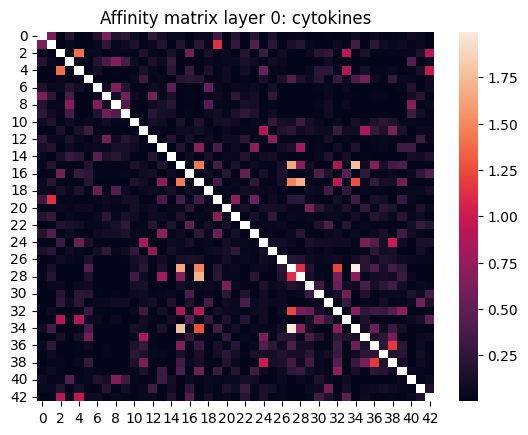

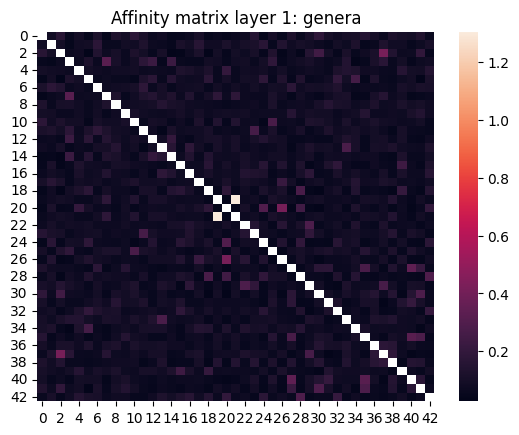

In [ ]:
for i,data_type in enumerate(type_input):
    matrix = affinities[i].copy()
    np.fill_diagonal(matrix, np.nan)
    ax = plt.axes()
    sns.heatmap(matrix, annot=False, ax=ax)
    ax.set_title(f'Affinity matrix layer {i}: {data_type}')
    plt.show()



Call Similarity Network Fusion and generate a fused matrix

In [9]:
fused = snf.snf(affinities)
fused.shape

(43, 43)

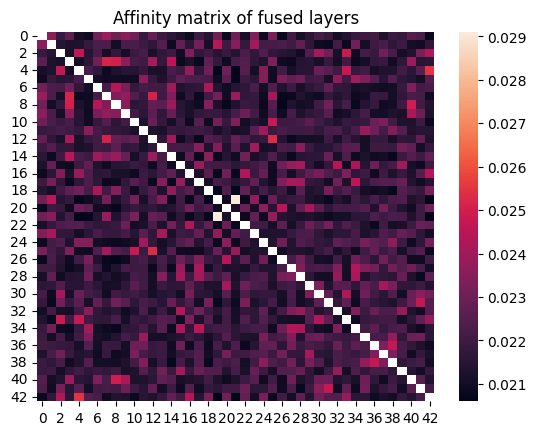

In [ ]:
matrix = fused.copy()
np.fill_diagonal(matrix, np.nan)

ax = plt.axes()
sns.heatmap(matrix, annot=False, ax=ax)
ax.set_title('Affinity matrix of fused layers')
plt.show()

SNF library also has a function to calculate the optimal number of clusters

In [ ]:
# we'll only use the first
first, second = snf.get_n_clusters(fused)
first, second

(4, 3)

Represent multi-dimensional data in a 2D space with TSNE or PCA

In [12]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(fused)

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(fused)


In [14]:
if dim_red == "pca":
    data = pca_data
elif dim_red == "tsne":
    data = tsne_data

string_data = ''
for i in type_input:
    string_data += i
    string_data += " "

Cluster the fused matrix with HDBSCAN

In [36]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN(min_cluster_size=2, min_samples=3, alpha=1.0, cluster_selection_method="leaf", cluster_selection_epsilon=0.01)
hdb.fit(data)
labels = hdb.labels_

In [37]:
df = pd.DataFrame(data)
df['Cluster'] = labels
df = df.set_index(names)

ValueError: Length mismatch: Expected 41 rows, received array of length 43

In [17]:
# df['Cluster'].to_csv("./tmp.csv")

Scatter plot of the data with the labels assigned by HDBSCAN

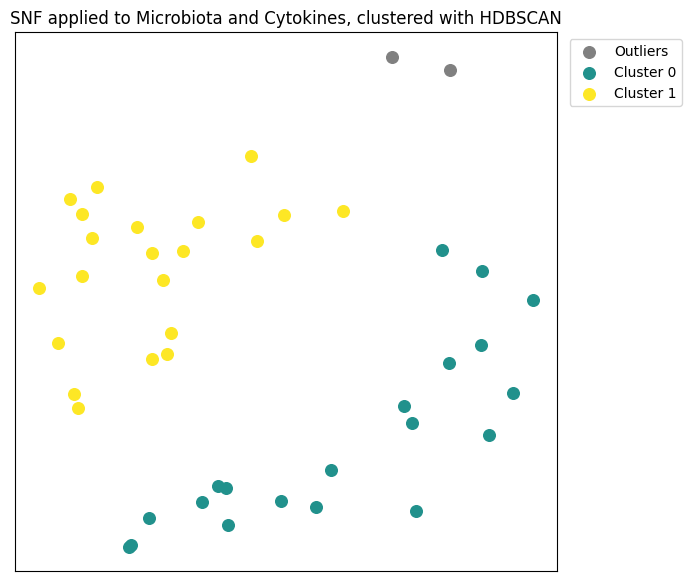

In [ ]:
from matplotlib.pyplot import cm
df_sorted = df.sort_values(by='Cluster')

plt.figure(figsize=(7, 7))

# cmap_iter = plt.cm.get_cmap('viridis', len(["noise", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]))
colors = cm.viridis(np.linspace(0, 1, len(set(labels))))

# Plot points with different colors for each cluster
for i, cluster in enumerate(df_sorted['Cluster'].unique()):
    cluster_data = df_sorted[df_sorted['Cluster'] == cluster]
    names_cluster = list(cluster_data.index)
    color = colors[i]
    if cluster >= 0:
        plt.scatter(cluster_data[0], cluster_data[1], label=f'Cluster {cluster}', color=color, s=70)
        # for i, txt in enumerate(names_cluster):
        #     plt.annotate(txt[-2:], (cluster_data.loc[txt, 0], cluster_data.loc[txt, 1]))
    else:
        plt.scatter(cluster_data[0], cluster_data[1], label=f'Outliers', s=70, color=(0.5, 0.5, 0.5))

plt.title("SNF applied to Microbiota and Cytokines, clustered with HDBSCAN")
# plt.xlabel('tSNE Component 1')
# plt.ylabel('tSNE Component 2')
plt.yticks([])
plt.xticks([])
plt.legend(bbox_to_anchor=(1.01, 1))
plt.show()

Plotting single layers represented with TSNE, with the labels given by HDBSCAN on the fused matrix

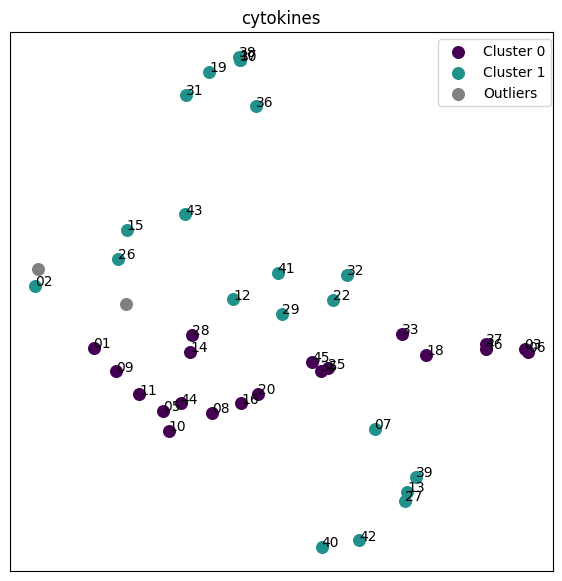

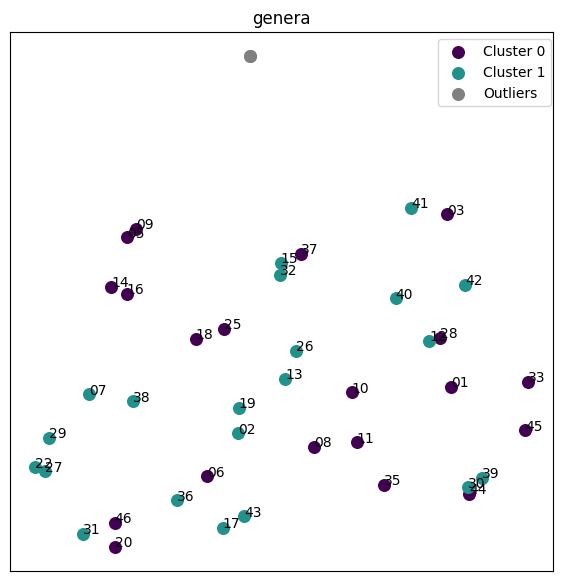

In [19]:
for i,data_type in enumerate(type_input):
    plt.figure(figsize=(7, 7))
    matrix = affinities[i].copy()
    # np.fill_diagonal(matrix, np.nan)

    tsne_data = tsne.fit_transform(matrix)
    df_type = pd.DataFrame(tsne_data, index = names)
    df_type['Cluster'] = labels

    for i, cluster in enumerate(df_type['Cluster'].unique()):
        cluster_data = df_type[df_type['Cluster'] == cluster]
        names_cluster = list(cluster_data.index)
        color = colors[i]
        if cluster >= 0:
            plt.scatter(cluster_data[0], cluster_data[1], label=f'Cluster {cluster}', color=color, s=70)
            for i, txt in enumerate(names_cluster):
                plt.annotate(txt[-2:], (cluster_data.loc[txt, 0], cluster_data.loc[txt, 1]))
        else:
            plt.scatter(cluster_data[0], cluster_data[1], label=f'Outliers', s=70, color=(0.5, 0.5, 0.5))

    plt.title(f"{data_type}")
    # plt.xlabel('tSNE Component 1')
    # plt.ylabel('tSNE Component 2')
    plt.yticks([])
    plt.xticks([])
    plt.legend(bbox_to_anchor=(1.01, 1))
    plt.show()
    

Calculate evaluation metrics for clustering that do not have ground trith labels:
- **Calinski-Harabasz Index**: The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion. The value of k that yields the maximum CH index is chosen as the optimal number of clusters. compare clustering solutions obtained on the same data, - solutions which differ either by the number of clusters or by the clustering method used.
- **Davies-Buldin Index**: The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score: lower values indicating better clustering.
- **Silhouette Score**: The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. 


In [20]:
# Calculate Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score

ch_index = calinski_harabasz_score(fused, labels)
print("Calinski-Harabasz Index:", round(ch_index, 3))

Calinski-Harabasz Index: 1.053


In [21]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(fused, labels)
print("Davies-Buoldin Index:", round(db_index, 3))

Davies-Buoldin Index: 4.77


In [22]:
from sklearn.metrics import silhouette_score

s_score = silhouette_score(fused, labels)
print("Silhouette Score:", round(s_score, 3))

Silhouette Score: 0.002


Match the identified subgroups with clinical information. This part is feature-specific, so it should be adjusted if the clinical features change

In [ ]:
clinical = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/test/clinical.csv", index_col = "id_microbio")
clinical = clinical[["age_molecular","sex"]]
clinical.head()

,age_molecular,sex
id_microbio,,
OM-001,71.8,M
OM-002,72.6,M
OM-003,72.6,M
OM-005,85.8,M
OM-006,63.9,F


In [ ]:
mr = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/test/response.csv", index_col="id")
mr = mr.set_index(names)


ema = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/test/ematologia.csv", index_col="id_microbio")
ema = ema.drop(columns="id")
ema = ema.drop(columns="Data prelievo")
ema = ema.reindex(mr.index)

targets = pd.concat([ema, mr, clinical], axis=1)
targets["cluster"] = labels
targets = targets[targets['cluster'] != -1]
targets.head()
    

,DAO,TMAO,ZONULINA,response,age_molecular,sex,cluster
id_microbio,,,,,,,
OM-001,13.9,89.2,54.0,True,71.8,M,0
OM-002,13.5,77.9,45.8,False,72.6,M,1
OM-003,16.7,81.7,47.6,True,72.6,M,0
OM-005,0.1,96.1,35.4,True,85.8,M,0
OM-006,15.4,73.9,31.0,True,63.9,F,0


TableOne

In [ ]:
from tableone import TableOne

columns     = list(targets.columns)
groupby     = ["cluster"]
categorical = ["response", "sex"]

nonnormal = ["DAO", "TMAO", "ZONULINA", "age_molecular"]

tableone = TableOne(targets, columns=columns, categorical=categorical, groupby=groupby, nonnormal=nonnormal, pval=True)
tableone
print(tableone.tabulate(tablefmt="latex"))

Grouped by cluster                                                              
                                               Missing           Overall                 0                 1 P-Value
n                                                                     41                20                21        
DAO, median [Q1,Q3]                                  1  15.6 [12.3,18.0]   15.4 [8.1,16.6]  15.9 [13.4,23.0]   0.343
TMAO, median [Q1,Q3]                                 2  77.6 [72.0,81.8]  81.3 [75.3,85.9]  74.8 [68.5,79.8]   0.016
ZONULINA, median [Q1,Q3]                             1  45.2 [36.6,53.1]  42.7 [36.0,50.8]  46.5 [39.0,53.1]   0.626
response, n (%)               False                  0         18 (43.9)          9 (45.0)          9 (42.9)   1.000
                              True                             23 (56.1)         11 (55.0)         12 (57.1)        
age_molecular, median [Q1,Q3]                        0  69.2 [56.6,79.3]  74.2 [64.9,84.9]  61.2 [42.3,71.8]   0.009
sex, n (%)                    F                      0         20 (48.8)         12 (60.0)          8 (38.1)   0.276
                              M                                21 (51.2)          8 (40.0)         13 (61.9)

In [26]:
results = {}

with pd.ExcelWriter("/nfs/home/deluca/phd/analisi_microbiota/output/per_feature_percentage_test.xlsx") as writer:

    for cluster in targets['cluster'].unique():
        results[cluster] = {}
        # print("Cluster ", cluster)
        data_cluster = targets.loc[targets["cluster"] == cluster]
        total_rows = len(data_cluster)
        for feature in data_cluster.columns[:-1]:
            # print(feature)
            results[cluster][feature] = {}
            feature_values = data_cluster[feature].dropna().unique()
            # print(feature_values)
            for feature_value in feature_values:
                # print(feature_value)
                count_rows = (data_cluster[feature] == feature_value).sum()
                percentage = round(count_rows / total_rows *100, 2)
                results[cluster][feature][feature_value] = percentage
                # print(percentage)

        df_results = pd.DataFrame(results[cluster])
        df_results.to_excel(writer, sheet_name=str(cluster), index=True)

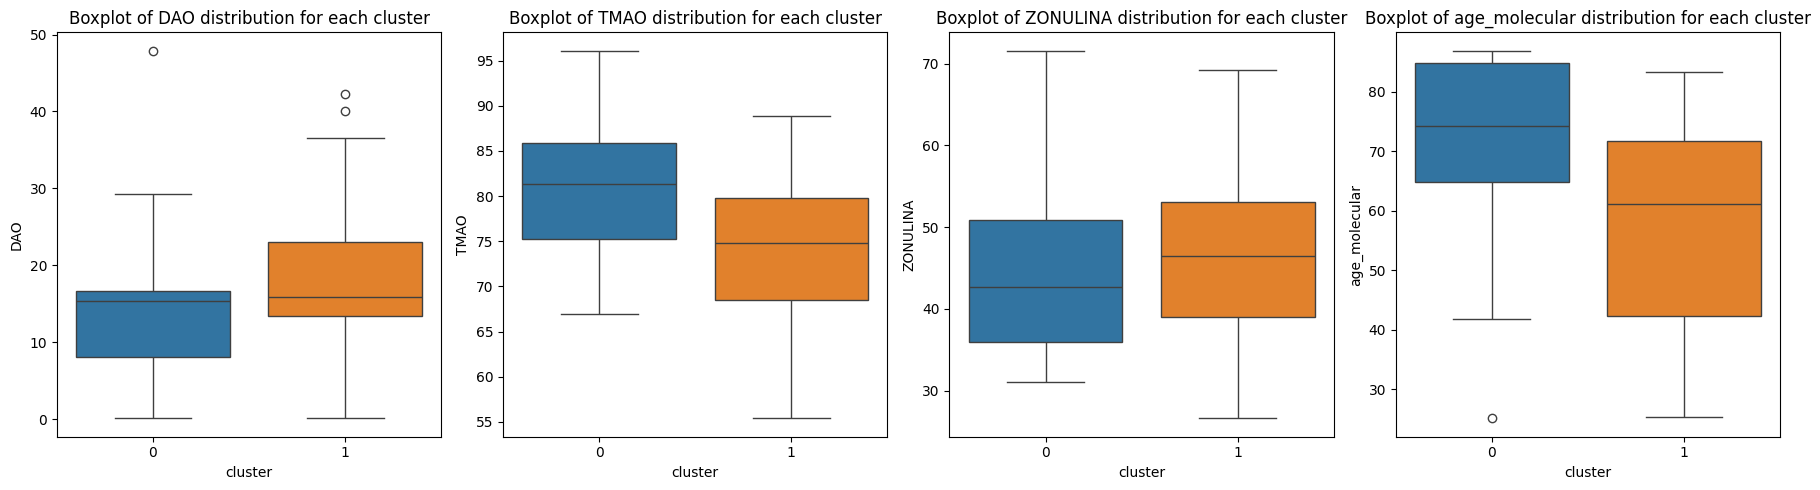

In [27]:
targets = targets.drop(columns=["response"])

fig, axes = plt.subplots(nrows=1, ncols=len(targets.columns[:-2]), figsize=(18, 5))

for i,feature in enumerate(targets.columns[:-2]):
    sns.boxplot(x='cluster', y=feature, data=targets, ax=axes[i], hue='cluster', legend=False)
    axes[i].set_title(f'Boxplot of {feature} distribution for each cluster')


plt.tight_layout()
plt.show()


In [28]:
cyto['cluster'] = labels
cyto = cyto[cyto['cluster'] != -1]

cyto_norm['cluster'] = labels
cyto_norm = cyto_norm[cyto_norm['cluster'] != -1]

genera_norm['cluster'] = labels
genera_norm = genera_norm[genera_norm['cluster'] != -1]

genera['cluster'] = labels
genera = genera[genera['cluster'] != -1]

In [29]:
# %%capture

# # fig, axes = plt.subplots(nrows=len(cyto.columns[:-1]), ncols=1, figsize=(5, 71))
# for i,feature in enumerate(cyto.columns[:-1]):
#     plt.figure(figsize=(7,7))
#     sns.boxplot(x='cluster', y=feature, data=cyto, hue='cluster', legend=False) #, ax=axes[i]
#     plt.title(f'Boxplot of cytokines for cluster {cluster}')
#     # axes[i].set_title(f'Boxplot of {feature} for each cluster')
    
# # plt.tight_layout()
#     plt.savefig(f"./images/cytokines/{feature}.png")

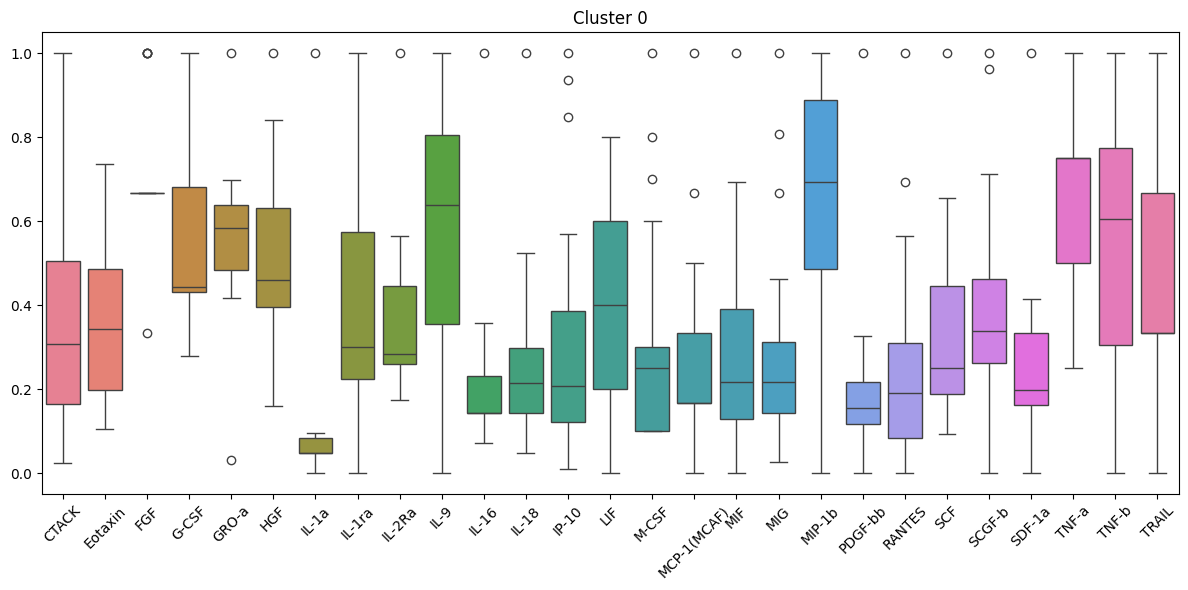

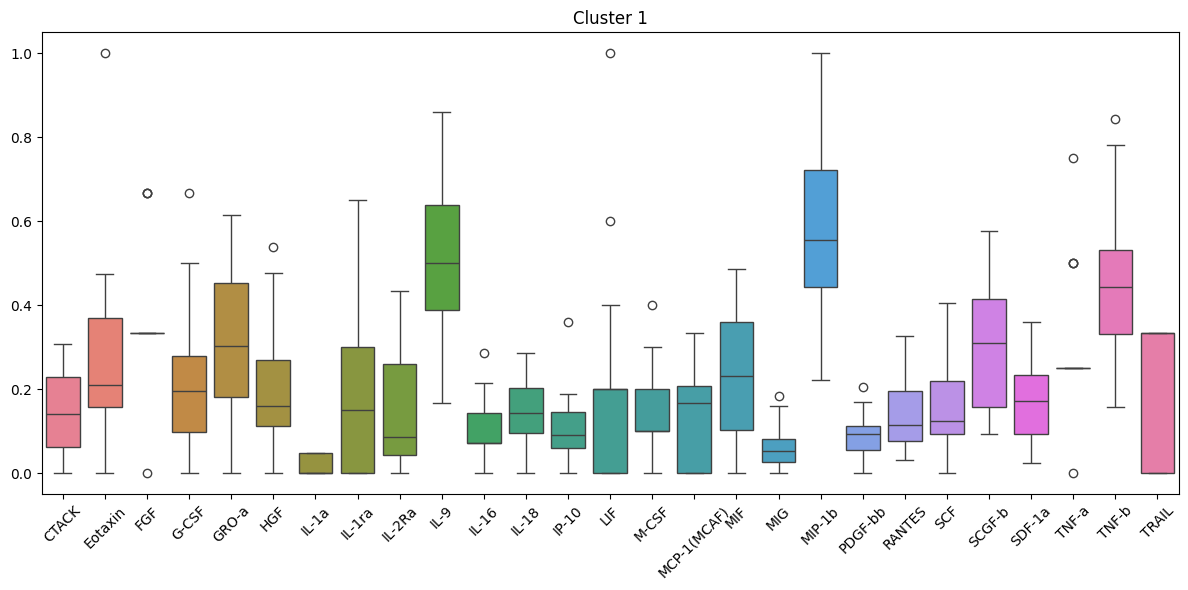

In [30]:
# Create subplots for each cluster
# fig, axes = plt.subplots(nrows=1, ncols=len(cyto['cluster'].unique()), figsize=(12, 6))
data = cyto_norm
# Iterate through each cluster and create boxplots
for i, cluster in enumerate(data['cluster'].unique()):
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[data['cluster'] == cluster].drop('cluster', axis=1))
    plt.title(f'Cluster {cluster}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

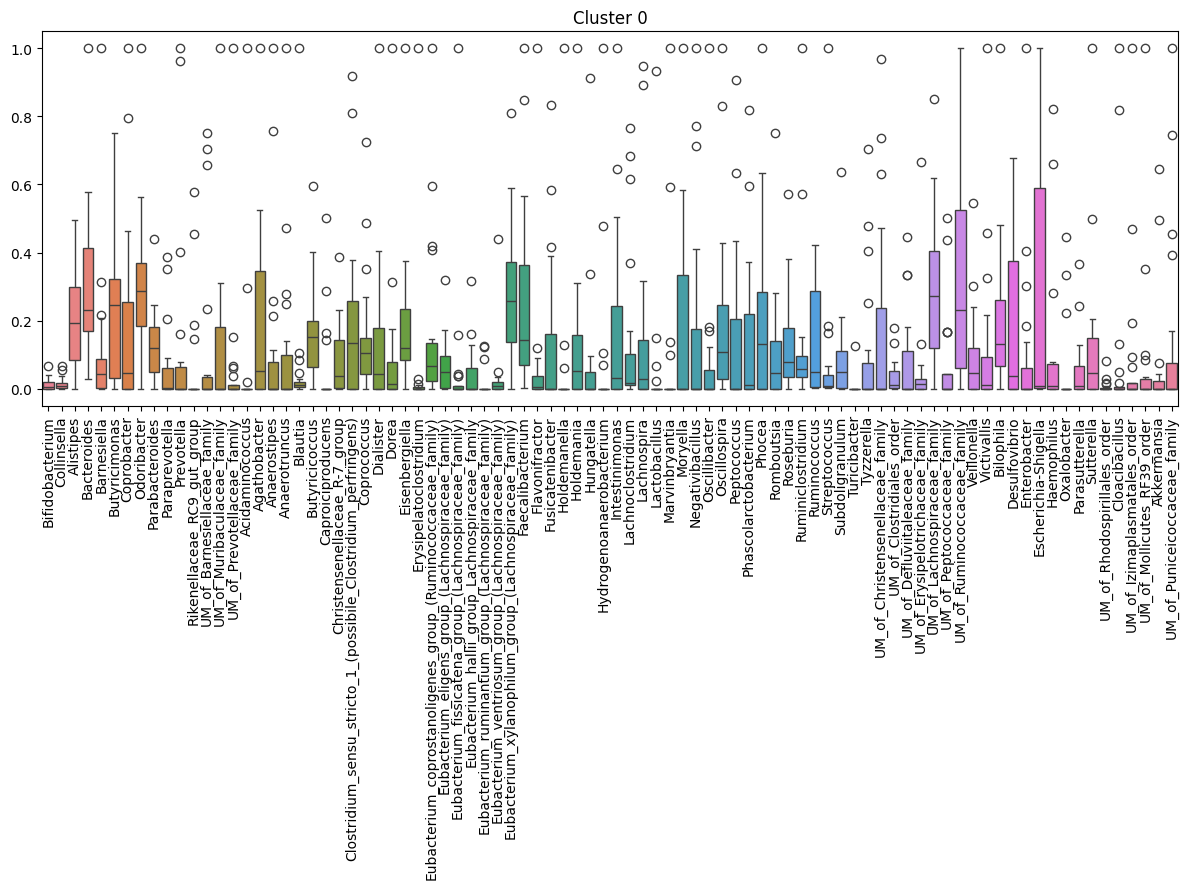

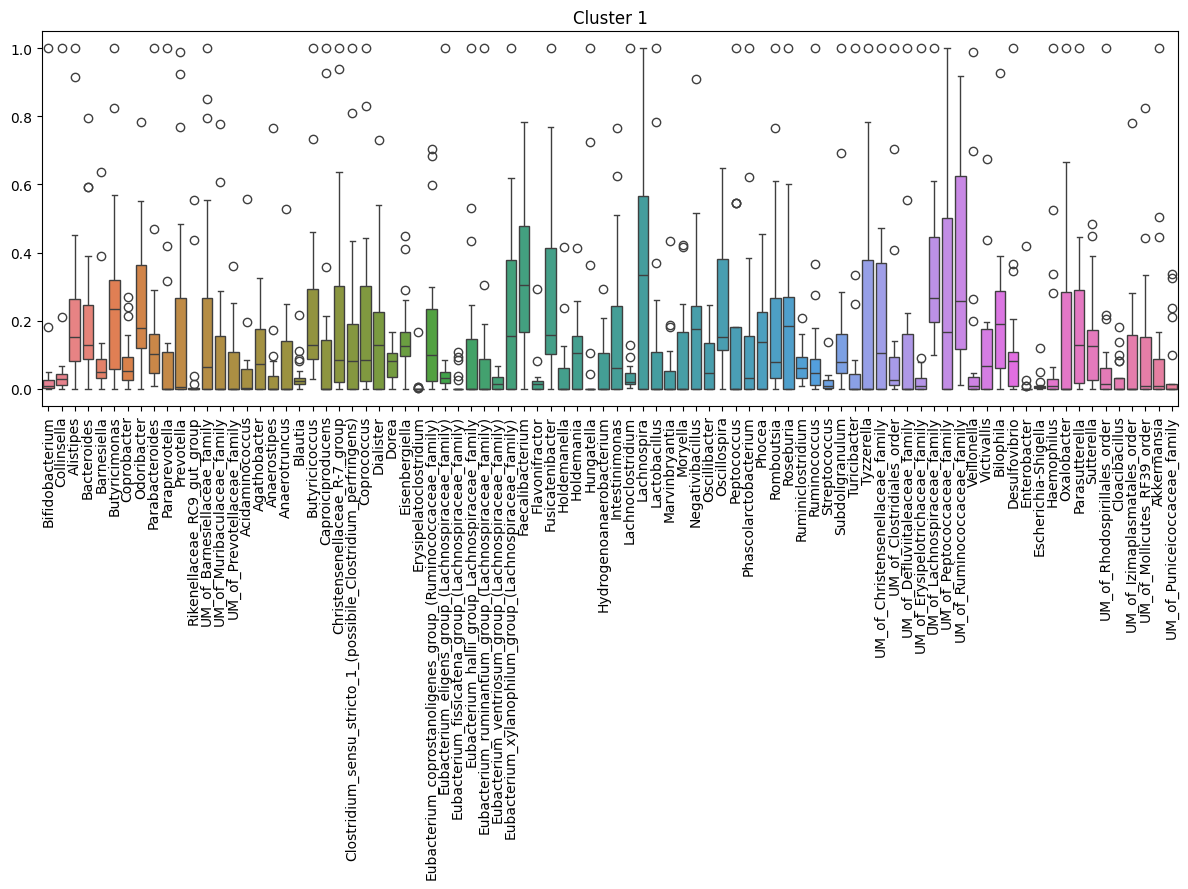

In [31]:
# Create subplots for each cluster
# fig, axes = plt.subplots(nrows=1, ncols=len(cyto['cluster'].unique()), figsize=(12, 6))
data = genera_norm
# Iterate through each cluster and create boxplots
for i, cluster in enumerate(data['cluster'].unique()):
    plt.figure(figsize=(12,9))
    sns.boxplot(data=data[data['cluster'] == cluster].drop('cluster', axis=1))
    plt.title(f'Cluster {cluster}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

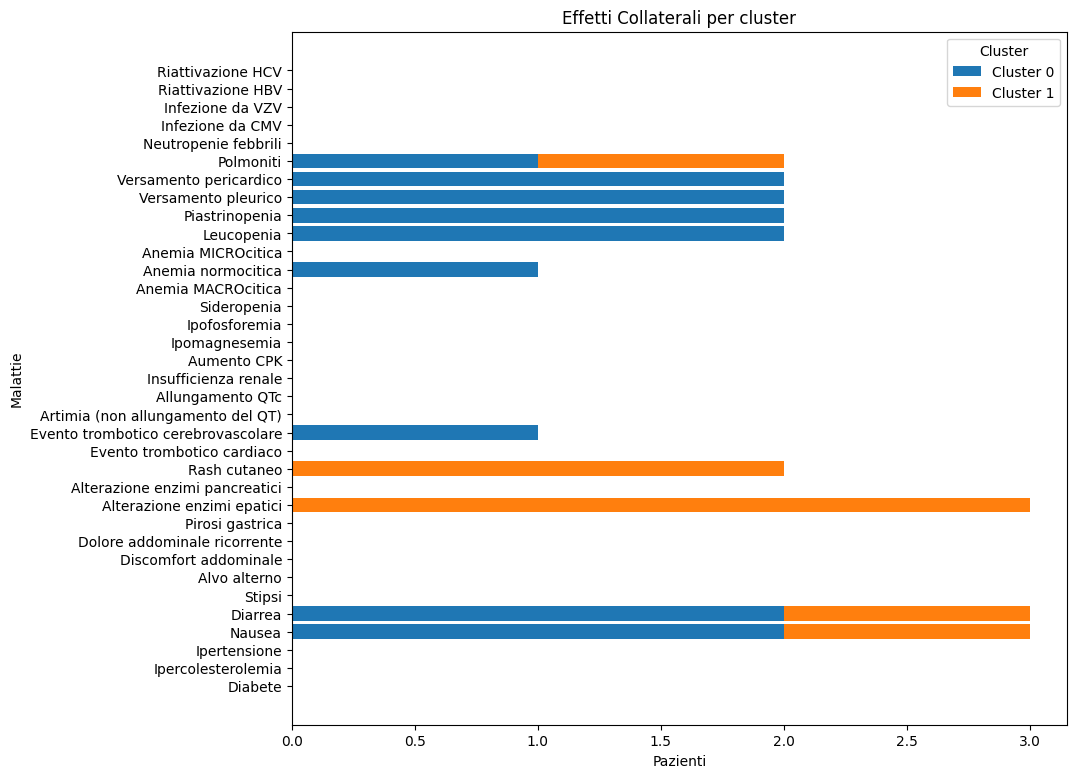

In [ ]:
effetti_collaterali = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/clinici/processed/effetti_collaterali.csv", header = 0, index_col=0)
effetti_collaterali = effetti_collaterali.drop([23, 34])
effetti_collaterali.reset_index()

effetti_collaterali['cluster'] = labels
diseases = effetti_collaterali.columns[1:-1]
cluster_counts = {}

for cluster in list(effetti_collaterali['cluster'].unique()):
    if cluster != -1:
        cluster_data = effetti_collaterali[effetti_collaterali['cluster'] == cluster]
        disease_count = cluster_data[diseases].apply(pd.Series.value_counts).fillna(0)
        cluster_counts[cluster] = disease_count

# Plotting stacked bar graph
fig, ax = plt.subplots(figsize=(10, 9))
bottom = [0] * len(diseases)
for cluster, disease_count in cluster_counts.items():
    bars = ax.barh(diseases, disease_count.loc['Yes'], label=f'Cluster {cluster}', left=bottom)
    bottom += disease_count.loc['Yes']
    # for bar, count in zip(bars, disease_count.loc['Sì']):
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}', ha='center', va='center', color='black', fontsize=8)
plt.title('Effetti Collaterali per cluster')
plt.ylabel('Malattie')
plt.xlabel('Pazienti')
plt.legend(title='Cluster')
plt.show()

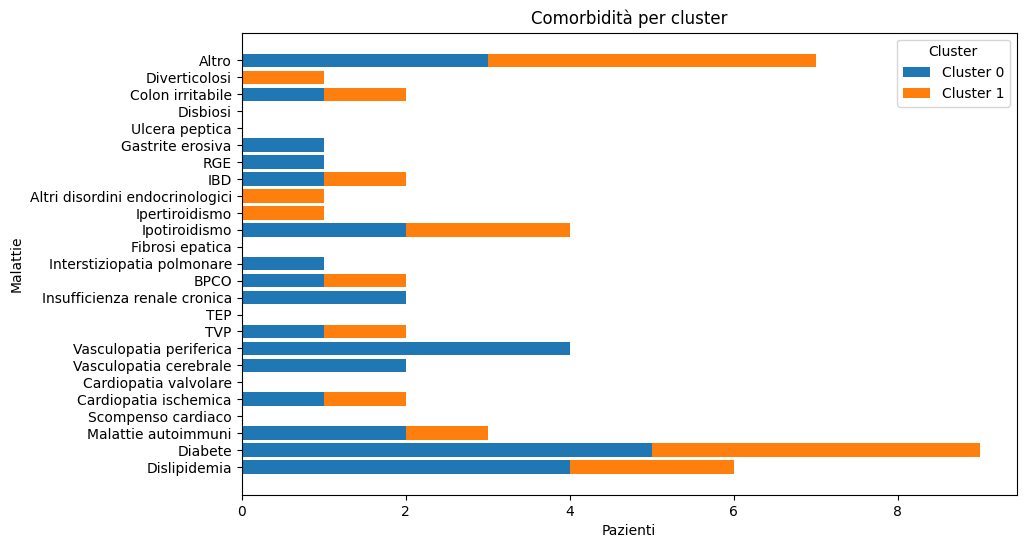

In [ ]:
comorbidita = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/clinici/processed/comorbidita.csv", header = 0, index_col=0)
comorbidita = comorbidita.drop([23, 34])
comorbidita.reset_index()

comorbidita['cluster'] = labels
diseases = comorbidita.columns[1:-1]
cluster_counts = {}

for cluster in list(comorbidita['cluster'].unique()):
    if cluster != -1:
        cluster_data = comorbidita[comorbidita['cluster'] == cluster]
        disease_count = cluster_data[diseases].apply(pd.Series.value_counts).fillna(0)
        cluster_counts[cluster] = disease_count

# Plotting stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bottom = [0] * len(diseases)
for cluster, disease_count in cluster_counts.items():
    bars = ax.barh(diseases, disease_count.loc['Sì'], label=f'Cluster {cluster}', left=bottom)    
    bottom += disease_count.loc['Sì']
    # for bar, count in zip(bars, disease_count.loc['Sì']):
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}', ha='center', va='center', color='black', fontsize=8)
plt.title('Comorbidità per cluster')
plt.ylabel('Malattie')
plt.xlabel('Pazienti')
plt.xticks()
plt.legend(title='Cluster')
plt.show()

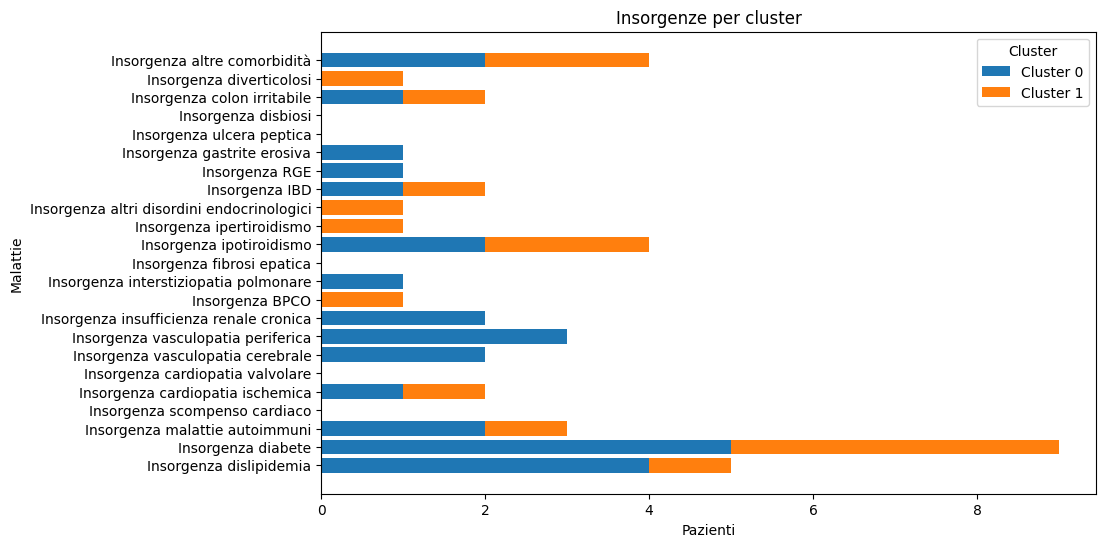

In [ ]:
insorgenze = pd.read_csv("/nfs/home/deluca/phd/analisi_microbiota/dati/clinici/processed/insorgenze.csv", header = 0, index_col=0)
insorgenze = insorgenze.drop([23, 34])
insorgenze.reset_index()

insorgenze['cluster'] = labels
diseases = insorgenze.columns[1:-1]
cluster_counts = {}

type_info = 'Yes'
insorgenze = insorgenze.replace({'In corso di trattamento':'Yes', 'Prima della diagnosi':'Yes'})

for cluster in list(insorgenze['cluster'].unique()):
    if cluster != -1:
        cluster_data = insorgenze[insorgenze['cluster'] == cluster]
        disease_count = cluster_data[diseases].apply(pd.Series.value_counts).fillna(0)
        cluster_counts[cluster] = disease_count

# Plotting stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bottom = [0] * len(diseases)
for cluster, disease_count in cluster_counts.items():
    bars = ax.barh(diseases, disease_count.loc[type_info], label=f'Cluster {cluster}', left=bottom)
    bottom += disease_count.loc[type_info]
    # for bar, count in zip(bars, disease_count.loc['Sì']):
    #     height = bar.get_height()
    #     ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(count)}', ha='center', va='center', color='black', fontsize=8)
plt.title('Insorgenze per cluster')
plt.ylabel('Malattie')
plt.xlabel('Pazienti')
plt.xticks()
plt.legend(title='Cluster')
plt.show()

What happens if I apply HDBSCAN to tsne represented data instead of to the fused similarity network? I want to check if it is better to apply clustering to fused network rather than t-sne representation

In [35]:

# Function to calculate clustering scores
def calculate_clustering_scores(X, labels):
    if len(set(labels)) > 1: 
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        sil_score = silhouette_score(X, labels)
        return ch_score, db_score, sil_score
    else:
        return np.nan, np.nan, np.nan  

results = []

results.append(["fused", ch_index, db_index, s_score])


tsne_dimensions = [2, 3, 5, 10, 20]

for dim in tsne_dimensions:

    tsne = TSNE(n_components=dim, random_state=42, method='exact')
    X_tsne = tsne.fit_transform(fused)

    hdb = HDBSCAN(min_cluster_size=3, min_samples=3, alpha=1.0, cluster_selection_method="leaf")
    hdb.fit(X_tsne)
    labels = hdb.labels_
    
    ch_score, db_score, sil_score = calculate_clustering_scores(X_tsne, labels)

    results.append([dim, ch_score, db_score, sil_score])

results_df = pd.DataFrame(results, columns=['t-SNE Dim', 'Calinski-Harabasz', 'Davies-Bouldin', 'Silhouette'])
results_df


,t-SNE Dim,Calinski-Harabasz,Davies-Bouldin,Silhouette
0,fused,1.052797,4.769811,0.001889
1,2,14.937764,1.970689,0.343818
2,3,2.312388,2.457252,-0.110518
3,5,0.846047,3.890352,-0.154373
4,10,0.211112,3.185779,-0.294041
5,20,0.330036,3.983002,-0.171457
